In [183]:
import Pkg
Pkg.add("PrettyTables")

    Updating registry at `C:\Users\matsz\.julia\registries\General.toml`
   Resolving package versions...
    Updating `C:\Users\matsz\.julia\environments\v1.10\Project.toml`
  [08abe8d2] + PrettyTables v2.3.1
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Manifest.toml`
Precompiling project...
  ✓ StaticArrays → StaticArraysChainRulesCoreExt
  ✓ BangBang → BangBangChainRulesCoreExt
  ✓ Distances → DistancesChainRulesCoreExt
  ✓ Roots
  ✓ MvNormalCDF
  ✓ AccessorsExtra → DistributionsExt
  ✓ LoopVectorization → ForwardDiffExt
  ✓ SciMLBase → SciMLBaseChainRulesCoreExt
  ✓ Roots → RootsForwardDiffExt
  ✓ Clustering
  ✓ DiffEqBase → DiffEqBaseChainRulesCoreExt
  ✓ WilliamsonTransforms
  ✓ FinanceCore
  ✓ DiffEqBase → DiffEqBaseDistributionsExt
  ✓ DiffEqNoiseProcess
  ✓ FinanceModels
  ✓ Copulas
  ✓ EconomicScenarioGenerators
  ✓ EconomicScenarioGenerators → FinanceModelsExt
  19 dependencies successfully precompiled in 57 seconds. 398 already precompiled.


In [184]:
using DataFrames, FredData, XLSX, SHA, Dates, CSV, TimeSeries, StatsBase, HiddenMarkovModels, Distributions, Plots, PrettyTables

In [91]:
function guess_init(n_scenarios)
    regimes_probs = rand(1:100,n_scenarios)
    return regimes_probs/sum(regimes_probs)
end

function guess_tmatrix(n_scenarios)
    regimes_probs = rand(1:100,n_scenarios,n_scenarios)
    return regimes_probs ./ sum(regimes_probs,dims=2)
end

function guess_distribution()
    sigma = rand(Uniform(0,0.25))
    means = rand(Uniform(-0.25,0.25))
    return Normal(means,sigma)
end

function train_hmm(data, n_scenarios = 2)

    function guess_distribution()
        sigma = rand(Uniform(0,0.25))
        means = rand(Uniform(-0.25,0.25))
        return Normal(means,sigma)
    end
    
    init_guess = guess_init(n_scenarios)
    guess_matrix = guess_tmatrix(n_scenarios)
    guess_dist = [guess_distribution() for s in 1:n_scenarios]
    hmm_guess = HMM(init_guess, guess_matrix, guess_dist);
    return hmm_est, loglikelihood_evolution = baum_welch(hmm_guess, data);
end 

train_hmm (generic function with 2 methods)

In [133]:
dict = Dict()
dict["one"] = 3
dict

Dict{Any, Any} with 1 entry:
  "one" => 3

In [3]:
function regime_summary(loglikehood,hmm_est, freq = 1)
    tm = transition_matrix(hmm_est),
    
    return DataFrame(Dict(
      "mu1" => mean(obs_distributions(hmm_est)[1]) * freq,
      "sig1" => std(obs_distributions(hmm_est)[1])*  freq^0.5,
      "mu2" => mean(obs_distributions(hmm_est)[2]) * freq,
      "sig2" => std(obs_distributions(hmm_est)[2])* freq^0.5,       
      "p11" =>  transition_matrix(hmm_est)[1,1],
      "p21" =>  transition_matrix(hmm_est)[2,1],
      "loglikehood" => last(loglikehood),
      "prob1" =>  transition_matrix(hmm_est)[2,1]/(transition_matrix(hmm_est)[1,2]+transition_matrix(hmm_est)[2,1])
      
  ))
  end

regime_summary (generic function with 2 methods)

In [138]:
function regime_summary(loglikehood,hmm_est, freq = 1)
    tm = transition_matrix(hmm_est),
    n_regimes = length(initialization(hmm_est))
    dict = Dict()
   
    return n_regimes
      
end


regime_summary (generic function with 2 methods)

In [4]:
source_data = TimeArray(CSV.File("assets_data_03.24.csv", delim=';', dateformat="u dd, yyyy", decimal=','),timestamp=:Date)
ACWI_PLN = source_data.ACWI_Net .* source_data.USDPLN
source_data = merge(source_data,ACWI_PLN)
returns = log.(percentchange(source_data) .+ 1)

435×3 TimeArray{Union{Missing, Float64}, 2, Date, Matrix{Union{Missing, Float64}}} 1988-01-29 to 2024-03-29
┌────────────┬─────────────┬─────────────┬─────────────────┐
│            │ ACWI_Net    │ USDPLN      │ ACWI_Net_USDPLN │
├────────────┼─────────────┼─────────────┼─────────────────┤
│ 1988-01-29 │   0.0246253 │     missing │         missing │
│ 1988-02-29 │   0.0560778 │     missing │         missing │
│ 1988-03-31 │   0.0302388 │     missing │         missing │
│ 1988-04-29 │   0.0125024 │     missing │         missing │
│ 1988-05-31 │  -0.0201209 │     missing │         missing │
│ 1988-06-30 │ -0.00119203 │     missing │         missing │
│ 1988-07-29 │     0.01818 │     missing │         missing │
│ 1988-08-31 │  -0.0566908 │     missing │         missing │
│     ⋮      │      ⋮      │      ⋮      │        ⋮        │
│ 2023-09-29 │   -0.042229 │   0.0576333 │       0.0154043 │
│ 2023-10-31 │   -0.030529 │  -0.0361159 │       -0.066645 │
│ 2023-11-30 │   0.0882833 │  -0.05258

In [129]:
stats = summarystats.(eachcol(values(returns)))

stats = DataFrame([stats[1],stats[2],stats[3]])


Row,mean,sd,min,q25,median,q75,max,nobs,nmiss
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64
1,0.00622469,0.0443616,-0.220834,-0.0181497,0.0124942,0.0330787,0.116238,435,0
2,0.000397277,0.0371301,-0.094026,-0.0247304,-0.00190905,0.0234364,0.166496,435,120
3,0.00581535,0.0380711,-0.111985,-0.0159863,0.00790445,0.0323534,0.105947,435,120


In [6]:
stats[:,1] *12

3-element Vector{Float64}:
 0.07469630583902334
 0.0047673239504150075
 0.06978414857853404

In [53]:
stats[:,2] *12^0.5

3-element Vector{Float64}:
 0.15367294034595488
 0.12862229739242811
 0.13188217654652964

In [119]:
acwi_long = identity.(values(returns[:ACWI_Net]))
hmm_est, loglikehood = train_hmm(acwi_long,2)
println("ACWI long 2")
regime_summary(loglikehood,hmm_est,12)

ACWI long 2


Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,774.685,-0.0115754,0.16069,0.941967,0.0597864,0.50744,0.195714,0.0873572


In [139]:
acwi_long = identity.(values(returns[:ACWI_Net]))
hmm_est, loglikehood = train_hmm(acwi_long,4)
println("ACWI long 4")
regime_summary(loglikehood,hmm_est,12)

ACWI long 4

BoundsError: BoundsError: attempt to access Int64 at index [2]

In [93]:
acwi_98 = identity.(values(from(returns[:ACWI_Net],Date(1998,01,01))))
hmm_est, loglikehood = train_hmm(acwi_short,2)
regime_summary(loglikehood,hmm_est,12)

Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,493.23,0.166708,-0.0376449,0.944594,0.0566911,0.505731,0.0811341,0.205595


In [100]:
acwi_03 = identity.(values(from(returns[:ACWI_Net],Date(2003,01,01))))
hmm_est, loglikehood = train_hmm(acwi_short,2)
regime_summary(loglikehood,hmm_est,12)

Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,493.23,0.166705,-0.0376346,0.944603,0.0566774,0.505712,0.0811332,0.205592


In [101]:
acwi_pln_98 = identity.(values(from(returns[:ACWI_Net_USDPLN ],Date(1998,01,01))))
hmm_est, loglikehood = train_hmm(acwi_pln,2)
regime_summary(loglikehood,hmm_est,12)

Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,543.406,0.143816,-0.149772,0.958624,0.115471,0.7362,0.0911435,0.180197


In [109]:
acwi_pln_03 = identity.(values(from(returns[:ACWI_Net_USDPLN ],Date(2003,01,01))))
hmm_est, loglikehood = train_hmm(acwi_pln,2)
regime_summary(loglikehood,hmm_est,12)

Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,543.406,0.143817,-0.149775,0.958621,0.115479,0.736199,0.0911433,0.180197


In [110]:
function guess_init(n_scenarios)
    regimes_probs = rand(1:100,n_scenarios)
    return regimes_probs/sum(regimes_probs)
end

function guess_tmatrix(n_scenarios)
    regimes_probs = rand(1:100,n_scenarios,n_scenarios)
    return regimes_probs ./ sum(regimes_probs,dims=2)
end

function guess_distribution()
    corr = Matrix(1.0I,2,2)
    sigma = [rand(Uniform(0,0.25)),rand(Uniform(0,0.035))]
    means = [rand(Uniform(-0.5,0.5)),rand(Uniform(-0.01,0.12))]
    cov = cor2cov(corr,sigma)
    return MvNormal(means,cov)
end

using LinearAlgebra

In [115]:
acwi_and_pln = identity.(values(from(returns[:ACWI_Net_USDPLN, :USDPLN],Date(2001,01,01))))
n_scenarios = 2


init_guess = guess_init(n_scenarios)
guess_matrix = guess_tmatrix(n_scenarios)
guess_dist = [guess_distribution() for s in 1:n_scenarios]
hmm_guess = HMM(init_guess, guess_matrix, guess_dist);
println(hmm_guess)
hmm_est_concat, _ = baum_welch(hmm_guess, eachrow(acwi_and_pln));

Hidden Markov Model with:
 - initialization: [0.4666666666666667, 0.5333333333333333]
 - transition matrix: [0.5103448275862069 0.4896551724137931; 0.48091603053435117 0.5190839694656488]
 - observation distributions: [FullNormal(
dim: 2
μ: [0.07153873551044743, 0.10742260980071362]
Σ: [0.0226077253855422 0.0; 0.0 0.0005556241748958511]
)
, FullNormal(
dim: 2
μ: [0.4282025516287372, 0.009128886981363686]
Σ: [0.02386716986175943 0.0; 0.0 0.0010369690692649542]
)
]


In [116]:
dist1 = obs_distributions(hmm_est_concat)[1]
dist2 = obs_distributions(hmm_est_concat)[2]

mean1 = mean(dist1) .* 12
mean2 = mean(dist2) .* 12

std1 = sqrt.(var(dist1)) .* 12^0.5
std2 = sqrt.(var(dist2)) .* 12^0.5
display("means")
display([mean1 mean2])
display("std")
display([std1 std2])
display("corr")
cor1 = cor(dist1)
display(cor1)
cor2 = cor(dist2)
display(cor2)


"means"

2×2 Matrix{Float64}:
 -0.0728301   0.142591
  0.0548271  -0.0363066

"std"

2×2 Matrix{Float64}:
 0.170773  0.0861709
 0.158491  0.107953

"corr"

2×2 Matrix{Float64}:
 1.0        0.0866272
 0.0866272  1.0

2×2 Matrix{Float64}:
 1.0       0.592175
 0.592175  1.0

In [117]:
acwi_short = identity.(values(from(returns[:ACWI_Net],Date(2001,01,01))))
hmm_est, loglikehood = train_hmm(acwi_short,2)
obs_distributions(hmm_est)

2-element Vector{Normal{Float64}}:
 Normal{Float64}(μ=0.013891966413751811, σ=0.023420940405019706)
 Normal{Float64}(μ=-0.0031355236979571117, σ=0.059348677241386316)

In [118]:
acwi_short = identity.(from(returns[:ACWI_Net],Date(2001,01,01)))
hmm_est, loglikehood = train_hmm(values(acwi_short),2)
HMM(initialization(hmm_est), transition_matrix(hmm_est), obs_distributions(hmm_est))
states,_ = viterbi(hmm_est,values(acwi_short))
states = Float64.(states)

279-element Vector{Float64}:
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 ⋮
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0

In [34]:
acwi_states = merge(acwi_short,identity.(from((returns[:USDPLN]),Date(2001,01,01))),TimeArray(timestamp(acwi_short),states))
CSV.write("states",acwi_states)


"states"

In [36]:
first_regime = acwi_states[findwhen(acwi_states[:A] .== 1.0)]
second_regime = acwi_states[findwhen(acwi_states[:A] .== 2.0)]

println("First usd pln")
println(mean(values(first_regime[:USDPLN]))*12)
println(std(values(first_regime[:USDPLN]))*12^0.5)
println(cor(values(first_regime[:USDPLN]),values(first_regime[:ACWI_Net ])))

println("Second usd pln")
println(mean(values(second_regime[:USDPLN]))*12)
println(std(values(second_regime[:USDPLN]))*12^0.5)
println(cor(values(second_regime[:USDPLN]),values(second_regime[:ACWI_Net])))

First usd pln
-0.029791512628015195
0.104989023291778
-0.552543385302522
Second usd pln
0.023239055189205573
0.14920806835446282
-0.6632535242025056


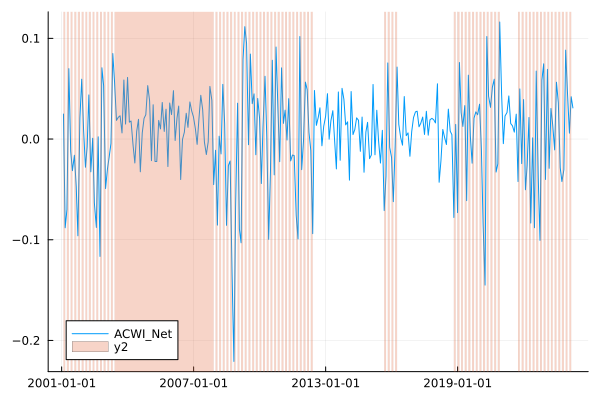

In [46]:
plot(acwi_states[:ACWI_Net ])
vspan!(findwhen(acwi_states[:A] .== 2.0),alpha = 0.3)

In [140]:
using ScenTrees, SDDP

In [206]:
n_steps = 25
n_scenarios = 5000
simulations = rand(Normal(0.07,0.132),(n_scenarios,n_steps)) 

simulation_perc = zeros(5,n_steps)
for t in 1:n_steps
    simulation_perc[:,t] = quantile(simulations[:,t], [0.05, 0.25, 0.5, 0.75, 0.95])
end
pretty_table(simulation_perc, backend = Val(:html),header=1:n_steps, row_labels=[0.05, 0.25, 0.5, 0.75, 0.95])

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0.05,-0.147419,-0.14411,-0.150174,-0.143722,-0.150156,-0.141168,-0.146147,-0.145174,-0.15641,-0.144502,-0.158159,-0.139023,-0.142342,-0.155797,-0.14379,-0.150402,-0.142803,-0.146333,-0.140688,-0.144754,-0.152572,-0.143322,-0.152133,-0.148696,-0.146346
0.25,-0.0193712,-0.0210266,-0.021553,-0.0205816,-0.0192023,-0.0172389,-0.019896,-0.0205777,-0.0198049,-0.0237974,-0.0202272,-0.0184373,-0.0183423,-0.021245,-0.018615,-0.0222631,-0.018173,-0.0147164,-0.0191869,-0.0221705,-0.0203569,-0.0161786,-0.0179391,-0.0175294,-0.0144191
0.5,0.0673422,0.0682755,0.0695105,0.0672526,0.0711057,0.0724212,0.0726357,0.0694194,0.069621,0.0675548,0.0679142,0.0738768,0.0703748,0.0672216,0.0721803,0.0673163,0.0719761,0.0727251,0.0736668,0.0683,0.0672602,0.0722303,0.0702265,0.0705962,0.0728981
0.75,0.157303,0.158786,0.159668,0.157237,0.159935,0.158013,0.158838,0.159161,0.157869,0.157187,0.159591,0.164449,0.159695,0.160779,0.158567,0.153704,0.158698,0.164647,0.16185,0.155827,0.160922,0.158479,0.159793,0.159609,0.163836
0.95,0.285627,0.292508,0.291244,0.286087,0.288205,0.287833,0.288185,0.287808,0.282662,0.28324,0.288456,0.292807,0.284036,0.291636,0.286319,0.28475,0.291903,0.292351,0.292277,0.279487,0.289189,0.287724,0.288682,0.284159,0.28845


In [207]:
hmm = HMM([1.,0],[0.85 0.15; 0.41 0.59],[Normal(0.0986,0.1041),Normal(0.0291,0.1435)])
simulations = zeros(n_scenarios,n_steps)
for s in 1:n_scenarios
    simulations[s,:] .= rand(hmm,n_steps)[2]
end

simulation_perc = zeros(5,n_steps)
for t in 1:n_steps
    simulation_perc[:,t] = quantile(simulations[:,t], [0.05, 0.25, 0.5, 0.75, 0.95])
end

pretty_table(simulation_perc, backend = Val(:html),header=1:n_steps, row_labels=[0.05, 0.25, 0.5, 0.75, 0.95])

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0.05,-0.0715748,-0.103072,-0.113128,-0.117742,-0.128601,-0.122366,-0.131156,-0.130977,-0.129672,-0.12976,-0.126825,-0.122813,-0.119401,-0.120753,-0.125109,-0.129763,-0.124506,-0.125094,-0.122475,-0.134313,-0.126194,-0.119766,-0.129086,-0.129573,-0.118308
0.25,0.0270593,0.0155606,0.0124764,0.00675145,0.00427798,0.00367094,0.00533897,0.00497643,0.00440528,0.00172482,0.00178156,0.00815244,0.00612769,0.00398916,0.00449325,0.000891752,0.00627626,0.00824437,0.0036914,0.00104779,0.00368354,0.0085044,0.0052286,0.000248408,0.0057967
0.5,0.0962135,0.0911037,0.0910326,0.087986,0.0868709,0.0839514,0.0865627,0.0830978,0.0830779,0.0837076,0.0837595,0.0875448,0.0840134,0.0858302,0.0825449,0.0804037,0.0847794,0.0852516,0.0826885,0.0801812,0.0874446,0.0855932,0.0863545,0.0800876,0.0824938
0.75,0.169065,0.162176,0.162954,0.161411,0.159087,0.158963,0.164598,0.159956,0.160234,0.15944,0.161992,0.162513,0.161122,0.163156,0.161186,0.158424,0.162108,0.162393,0.159443,0.156959,0.162001,0.161366,0.161121,0.156848,0.159847
0.95,0.2656,0.268177,0.267616,0.265542,0.266909,0.263297,0.272183,0.270251,0.270729,0.263792,0.271337,0.264453,0.266495,0.272931,0.275759,0.261808,0.266825,0.271662,0.271083,0.271503,0.269007,0.267418,0.269374,0.270565,0.261921


In [200]:
rand(hmm,n_steps)

(state_seq = [1, 1, 1, 1, 2, 1, 1, 2, 2, 2  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], obs_seq = [-0.006415812592460907, -0.07751008245905083, 0.19151492165700384, 0.0755945662137717, 0.08903855280480415, 0.10327179869189243, 0.09937510453537901, 0.12260169284119077, -0.08908279341784119, 0.2749429896929457  …  -0.06753090096405573, 0.13746472149845596, 0.09147374265443567, 0.13892766960845554, -0.050642082089323054, 0.08299478808678483, 0.31592066982047773, 0.06442955676415482, 0.030169315049345807, 0.15714728514871715])